In [ ]:
!pip install pypsa
!pip install cartopy
from google.colab import drive
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import os

drive.mount('/content/drive')

network_file= "elec_s_10_ec_lc1.0_1h.nc"

# Construct the full path to the network file in Google Drive
gdrive_base = '/content/drive/MyDrive/Colab_Notebooks/networks_1_year_connected'
network_file_path = os.path.join(gdrive_base, network_file)

# # Load network
# network_file="/Users/antoniagrindrod/Documents/pypsa-earth_project/pypsa-earth-RL/networks/elec_s_10_ec_lc1.0_1h.nc"
# n = pypsa.Network(network_file)


In [4]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import os

In [1]:
def fix_artificial_lines_reasonable(network):
    """
    Fix artificial lines with reasonable capacity values:
    - s_nom = based on connected bus demand (with safety factor)
    - s_nom_extendable = False (non-extendable)
    - Keep capacity high enough to meet demand
    """
    print("=== FIXING ARTIFICIAL LINES WITH REASONABLE CAPACITY ===")

    # Find artificial lines
    artificial_lines = [line for line in network.lines.index
                       if any(keyword in str(line).lower() for keyword in ['new', '<->', 'artificial'])]

    if not artificial_lines:
        # If no artificial lines found by name, look for lines with s_nom=0
        # which is often a sign of artificial lines
        zero_capacity_lines = network.lines[network.lines.s_nom == 0].index.tolist()
        if zero_capacity_lines:
            artificial_lines = zero_capacity_lines

    print(f"Found {len(artificial_lines)} artificial lines to fix:")

    # Get maximum demand per bus across all snapshots
    bus_max_demand = {}
    for bus in network.buses.index:
        bus_demand = 0
        for load_name, load in network.loads.iterrows():
            if load.bus == bus and load_name in network.loads_t.p_set.columns:
                bus_demand = max(bus_demand, network.loads_t.p_set[load_name].max())
        bus_max_demand[bus] = bus_demand

    # Fix each artificial line with reasonable capacity
    for line_name in artificial_lines:
        # Get connected buses
        bus0 = network.lines.loc[line_name, 'bus0']
        bus1 = network.lines.loc[line_name, 'bus1']

        # Get maximum demand at these buses
        bus0_demand = bus_max_demand.get(bus0, 0)
        bus1_demand = bus_max_demand.get(bus1, 0)

        # Calculate required capacity with safety factor
        # Use 3x the higher demand to ensure adequate capacity
        safety_factor = 3.0
        required_capacity = max(bus0_demand, bus1_demand) * safety_factor

        # Ensure minimum reasonable capacity (1000 MW)
        required_capacity = max(required_capacity, 1000)

        print(f"\n Fixing: {line_name}")
        print(f"    Connected buses: {bus0} ↔ {bus1}")
        print(f"    Bus demands: {bus0}: {bus0_demand:.1f} MW, {bus1}: {bus1_demand:.1f} MW")

        # Set s_nom to required capacity
        old_s_nom = network.lines.loc[line_name, 's_nom']
        network.lines.loc[line_name, 's_nom'] = required_capacity
        print(f"    s_nom: {old_s_nom} → {required_capacity:.1f} MW")

        # Make sure line is not extendable
        if 's_nom_extendable' not in network.lines.columns:
            network.lines['s_nom_extendable'] = False
        network.lines.loc[line_name, 's_nom_extendable'] = False
        print(f"    s_nom_extendable: → False")

    return network

def remove_offshore_wind(network):
    """
    Remove offshore wind generators. 
    All of these have zero nominal capacity (likely missing data). 
    Need to remove them to avoid division by zero error in constraint check for slack gens.
    Problem is still feasible without offwind slack since pypsa optimize still feasible.
    """
    
    # First, identify offshore wind generators
    offwind_gens = network.generators[
        network.generators.index.str.contains('offwind', case=False, na=False)
    ].index
    
    print(f"Found {len(offwind_gens)} offshore wind generators:")
    print(offwind_gens.tolist())
    
    # Check their properties
    offwind_data = network.generators.loc[offwind_gens, ['p_nom', 'control', 'carrier']]
    print("\nOffshore wind generator details:")
    print(offwind_data)
    
    # Remove offshore wind generators one by one
    print(f"\nRemoving {len(offwind_gens)} offshore wind generators...")
    for gen in offwind_gens:
        network.remove("Generator", gen)

def create_pypsa_network(network_file):
    """Create a PyPSA network from the .nc file."""
    # Initialize network
    network = pypsa.Network(network_file)
    for storage_name in network.storage_units.index:
        # Use .loc for direct assignment to avoid SettingWithCopyWarning
        network.storage_units.loc[storage_name, 'cyclic_state_of_charge'] = False

        # Set marginal_cost to 0.01
        network.storage_units.loc[storage_name, 'marginal_cost'] = 0.01

        # Set marginal_cost_storage to 0.01
        network.storage_units.loc[storage_name, 'marginal_cost_storage'] = 0.01

        # Set spill_cost to 0.1
        network.storage_units.loc[storage_name, 'spill_cost'] = 0.1

        network.storage_units.loc[storage_name, 'efficiency_store'] = 0.866025 #use phs efficiency (hydro didnt have an efficiency, but i want to model them all as the same)

        # Fix unrealistic max_hours values
        current_max_hours = network.storage_units.loc[storage_name, 'max_hours']

        if 'PHS' in storage_name:
            # PHS with missing data - set to typical range
            network.storage_units.loc[storage_name, 'max_hours'] = 8.0
            print(f"Fixed {storage_name}: set max_hours to 8.0")

        elif 'hydro' in storage_name:
            # Hydro with unrealistic data - set to validated range
            network.storage_units.loc[storage_name, 'max_hours'] = 6.0
            print(f"Fixed {storage_name}: corrected max_hours from {current_max_hours} to 6.0")


    fix_artificial_lines_reasonable(network)
    remove_offshore_wind(network)

    return network

In [8]:
import pypsa
base_path="/Users/antoniagrindrod/Documents/pypsa-earth_project/pypsa-earth-RL/RL/elec_s_10_ec_lc1.0_1h.nc"
network=create_pypsa_network(base_path)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_1h.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


Fixed ZA0 0 PHS: set max_hours to 8.0
Fixed ZA0 5 PHS: set max_hours to 8.0
Fixed ZA0 6 hydro: corrected max_hours from 3831.6270020496813 to 6.0
=== FIXING ARTIFICIAL LINES WITH REASONABLE CAPACITY ===
Found 3 artificial lines to fix:

 Fixing: lines new ZA0 4 <-> ZA2 0 AC
    Connected buses: ZA0 4 ↔ ZA2 0
    Bus demands: ZA0 4: 15945.8 MW, ZA2 0: 452.6 MW
    s_nom: 0.0 → 47837.3 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA1 0 AC
    Connected buses: ZA0 0 ↔ ZA1 0
    Bus demands: ZA0 0: 3513.0 MW, ZA1 0: 1386.9 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA3 0 AC
    Connected buses: ZA0 0 ↔ ZA3 0
    Bus demands: ZA0 0: 3513.0 MW, ZA3 0: 721.1 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False
Found 12 offshore wind generators:
['ZA0 1 offwind-ac', 'ZA0 1 offwind-dc', 'ZA0 5 offwind-ac', 'ZA0 5 offwind-dc', 'ZA0 7 offwind-ac', 'ZA0 7 offwind-dc', 'ZA0 8 offwind-ac', 'ZA0 8 offwind-dc', 'ZA1 0 offwind-ac

/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


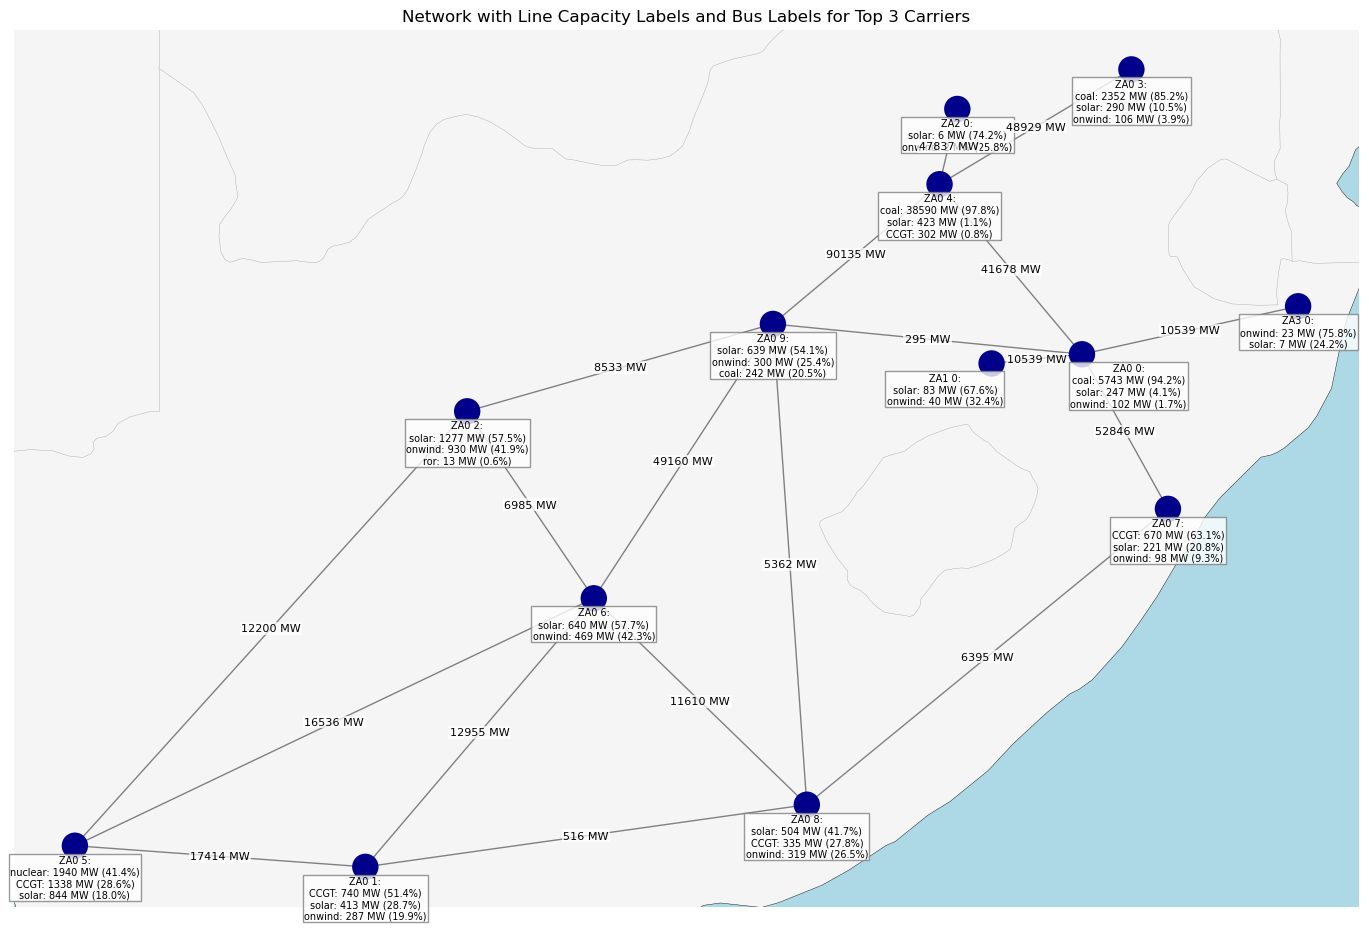

In [12]:
# Customizable function for bus labels with top carriers
def plot_network_with_bus_labels(network, num_top_carriers=3, figsize=(14, 10),
                               show_percentages=True, label_offset=(0.1, 0.1)):
    """
    Plot network with uniform bus sizes and labels showing top carriers.

    Parameters:
    -----------
    network : pypsa.Network
        The PyPSA network to plot
    num_top_carriers : int, optional
        Number of top carriers to show for each bus (default: 3)
    figsize : tuple, optional
        Figure size (default: (14, 10))
    show_percentages : bool, optional
        Whether to show percentages in labels (default: True)
    label_offset : tuple, optional
        (x, y) offset for label positioning (default: (0.1, 0.1))
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()})

    # Plot network with uniform bus sizes
    network.plot(
        ax=ax,
        bus_sizes=0.02,  # Uniform size for all buses
        bus_colors='darkblue',  # Uniform color for all buses
        line_widths=1.0,  # Uniform line width
        line_colors='gray',
        title=f"Network with Line Capacity Labels and Bus Labels for Top {num_top_carriers} Carriers",
        color_geomap=True,
        geomap=True,
    )

    # Calculate generation stats by bus and carrier
    if not network.generators.empty:
        # Group generators by bus and carrier, and sum their capacities
        bus_carrier_stats = network.generators.groupby(['bus', 'carrier'])['p_nom'].sum().reset_index()

        # Calculate total capacity per bus for percentage calculation
        bus_total_capacity = bus_carrier_stats.groupby('bus')['p_nom'].sum()

        # Get top carriers for each bus
        bus_stats = {}
        for bus in network.buses.index:
            # Get generators at this bus
            bus_data = bus_carrier_stats[bus_carrier_stats.bus == bus]
            if not bus_data.empty:
                # Sort by capacity (descending) and take top N
                top_carriers = bus_data.sort_values('p_nom', ascending=False).head(num_top_carriers)
                bus_stats[bus] = top_carriers

        # Add labels to buses with offset to avoid overlap with bus markers
        for bus, top_carriers in bus_stats.items():
            x, y = network.buses.at[bus, 'x'], network.buses.at[bus, 'y']
            
            # Special handling for overlapping buses ZA0 0 and ZA1 0
            x_offset = 0
            if bus == 'ZA0 0':
                x_offset = 0.5  # Move ZA0 0 label to the left
            elif bus == 'ZA1 0':
                x_offset = -0.5   # Move ZA1 0 label to the right

            # Get total capacity for this bus
            total_capacity = bus_total_capacity.get(bus, 0)

            # Format label text with top carriers, their capacities and percentages
            label_lines = [f"{bus}:"]
            for _, row in top_carriers.iterrows():
                carrier = row['carrier']
                capacity = int(round(row['p_nom']))

                if show_percentages and total_capacity > 0:
                    percentage = (row['p_nom'] / total_capacity) * 100
                    label_lines.append(f"{carrier}: {capacity} MW ({percentage:.1f}%)")
                else:
                    label_lines.append(f"{carrier}: {capacity} MW")

            label_text = '\n'.join(label_lines)

            # Add label directly below the bus marker with special offset for ZA0 0 and ZA1 0
            ax.text(x + x_offset, y - label_offset[1], label_text,
                    fontsize=7,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', pad=1),
                    ha='center', va='top',
                    zorder=5)  # Higher zorder to ensure labels are on top

    #Add capacity labels to each line
    if not network.lines.empty:
        # Format capacity values for display (in MW)
        for line in network.lines.index:
            bus0 = network.lines.at[line, 'bus0']
            bus1 = network.lines.at[line, 'bus1']

            # Get bus coordinates
            x0, y0 = network.buses.at[bus0, 'x'], network.buses.at[bus0, 'y']
            x1, y1 = network.buses.at[bus1, 'x'], network.buses.at[bus1, 'y']

            # Calculate midpoint for label placement
            mid_x = (x0 + x1) / 2
            mid_y = (y0 + y1) / 2

            # Format capacity value (rounded to nearest integer MW)
            capacity = int(round(network.lines.at[line, 's_nom']))

            # Add label with capacity value
            ax.text(mid_x, mid_y, f"{capacity} MW",
                    fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                    ha='center', va='center',
                    zorder=5)  # Higher zorder to ensure labels are on top

    plt.tight_layout()
    return fig, ax

# Example usage: Show top 3 carriers with percentages
plot_network_with_bus_labels(network, num_top_carriers=3, show_percentages=True)

plt.show()

# Uncomment to try different options:
# Show top 2 carriers without percentages
# plot_network_with_bus_labels(n, num_top_carriers=2, show_percentages=False)
# plt.show()


In [ ]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load network
# network_file="/Users/antoniagrindrod/Documents/pypsa-earth_project/pypsa-earth-RL/networks/elec_s_5_ec_lcopt_3h.nc"
n = pypsa.Network(network_file)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_1h.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


/Users/antoniagrindrod/miniconda3/envs/pypsa-earth-rl/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


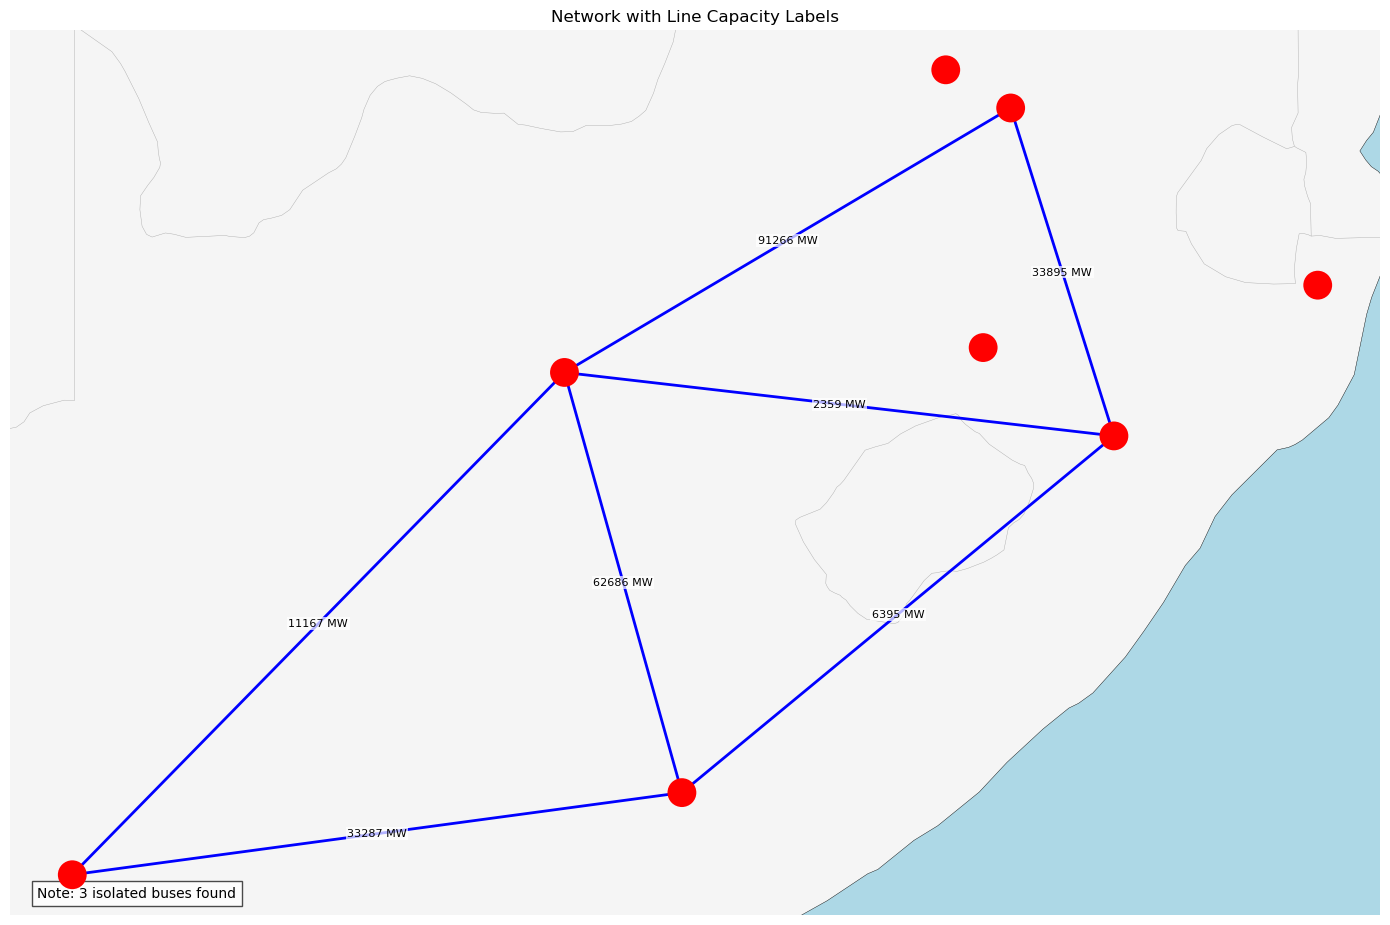

In [ ]:
# Visualize network with capacity labels instead of line thickness
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot network with uniform line thickness
n.plot(
    ax=ax,
    bus_sizes=0.02,
    bus_colors='red',
    line_widths=2,  # Uniform line width
    line_colors='blue',
    title="Network with Line Capacity Labels",
    color_geomap=True,
    geomap=True,
)

# Add capacity labels to each line
if not n.lines.empty:
    # Format capacity values for display (in MW)
    for line in n.lines.index:
        bus0 = n.lines.at[line, 'bus0']
        bus1 = n.lines.at[line, 'bus1']

        # Get bus coordinates
        x0, y0 = n.buses.at[bus0, 'x'], n.buses.at[bus0, 'y']
        x1, y1 = n.buses.at[bus1, 'x'], n.buses.at[bus1, 'y']

        # Calculate midpoint for label placement
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2

        # Format capacity value (rounded to nearest integer MW)
        capacity = int(round(n.lines.at[line, 's_nom']))

        # Add label with capacity value
        ax.text(mid_x, mid_y, f"{capacity} MW",
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                ha='center', va='center',
                zorder=5)  # Higher zorder to ensure labels are on top

# Add a note about disconnected buses
if 'isolated_buses' in locals() and len(isolated_buses) > 0:
    ax.text(0.02, 0.02, f"Note: {len(isolated_buses)} isolated buses found",
            transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


In [ ]:
print(n.lines)

      num_parallel  v_nom   bus0   bus1      length     dc  \
Line                                                         
0        19.602540  380.0  ZA0 0  ZA0 2  708.450417  False   
1         6.576316  380.0  ZA0 0  ZA0 3  895.762964  False   
2         3.765789  380.0  ZA0 1  ZA0 2  702.800210  False   
3         1.389474  380.0  ZA0 1  ZA0 3  664.223111  False   
4        19.960526  380.0  ZA0 1  ZA0 4  464.448620  False   
5        36.915606  380.0  ZA0 2  ZA0 3  589.505779  False   
6        53.745777  380.0  ZA0 3  ZA0 4  651.605614  False   

                                               geometry  \
Line                                                      
0     MULTILINESTRING ((20.01072339999996 -33.104816...   
1     MULTILINESTRING ((20.792915800000124 -29.49423...   
2     MULTILINESTRING ((28.3685 -31.0915, 28.3822105...   
3     MULTILINESTRING ((27.0844 -28.9435, 27.0852278...   
4     MULTILINESTRING ((29.7754 -27.0943, 29.7900769...   
5     MULTILINESTRING ((24.0

In [ ]:
# Check the structure of loads in the network
print("Loads in the network:")
if not n.loads.empty:
    print(f"Number of loads: {len(n.loads)}")
    print("\nLoad columns:")
    print(n.loads.columns.tolist())
    print("\nFirst few loads:")
    print(n.loads.head())

    # Check if time-varying data is available
    if hasattr(n, 'loads_t') and hasattr(n.loads_t, 'p_set'):
        print("\nTime-varying load data available:")
        print(f"Time periods: {len(n.loads_t.p_set)}")
        print(f"Time index: {n.loads_t.p_set.index[:5]}...")
        print("\nSample of load time series data:")
        print(n.loads_t.p_set.iloc[:5, :3])  # First 5 time steps, first 3 loads
    else:
        print("\nNo time-varying load data found in n.loads_t.p_set")
else:
    print("No loads found in the network")


Loads in the network:
Number of loads: 8

Load columns:
['bus', 'carrier', 'type', 'p_set', 'q_set', 'sign']

First few loads:
         bus carrier type  p_set  q_set  sign
Load                                         
ZA0 0  ZA0 0                 0.0    0.0  -1.0
ZA0 1  ZA0 1                 0.0    0.0  -1.0
ZA0 2  ZA0 2                 0.0    0.0  -1.0
ZA0 3  ZA0 3                 0.0    0.0  -1.0
ZA0 4  ZA0 4                 0.0    0.0  -1.0

Time-varying load data available:
Time periods: 2920
Time index: DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)...

Sample of load time series data:
Load                       ZA0 0        ZA0 1        ZA0 2
snapshot                                                  
2013-01-01 00:00:00  3202.097114  5828.719037  4393.962760
2013-01-01 03:00:00  3434.662460  6252.05350

Number of buses with loads: 13


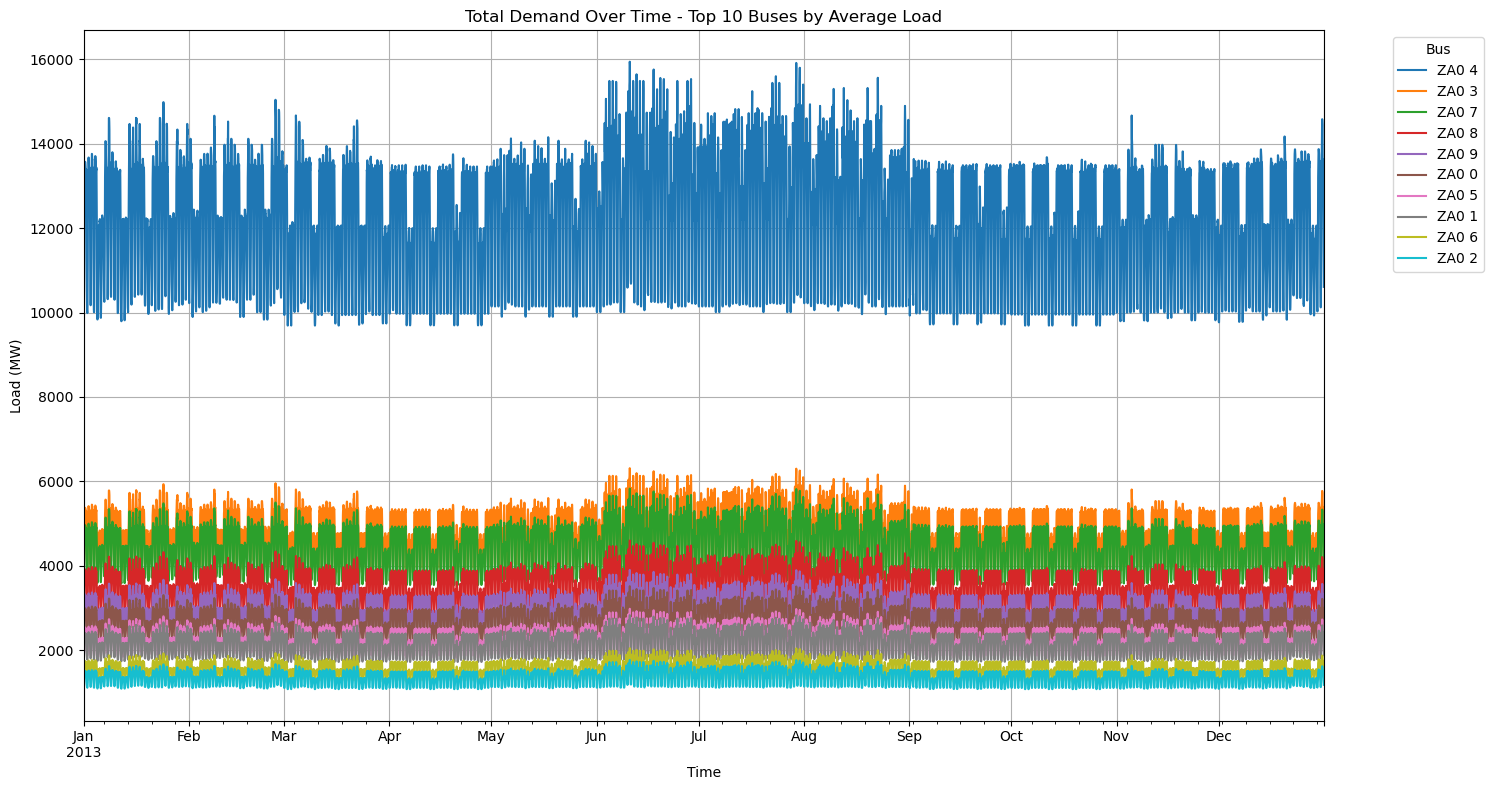


Summary statistics of bus demand:
        count          mean          std          min           25%  \
ZA0 4  8760.0  12235.611454  1437.710777  9692.132580  10784.530642   
ZA0 3  8760.0   4842.383383   568.990508  3835.772485   4268.101531   
ZA0 7  8760.0   4471.259764   525.382681  3541.796223   3940.991270   
ZA0 8  8760.0   3527.053995   414.436464  2793.867316   3108.763467   
ZA0 9  8760.0   2992.366268   351.609501  2370.327851   2637.486964   
ZA0 0  8760.0   2695.599234   316.738733  2135.251291   2375.914979   
ZA0 5  8760.0   2285.501167   268.551324  1810.402398   2014.452441   
ZA0 1  8760.0   2169.136308   254.878202  1718.226895   1911.887859   
ZA0 6  8760.0   1567.652405   184.202544  1241.776515   1381.736864   
ZA0 2  8760.0   1355.192687   159.238068  1073.481881   1194.473780   
ZA1 0  8760.0   1064.173066   125.042634   842.957991    937.967594   
ZA3 0  8760.0    553.322764    65.016620   438.300743    487.701520   
ZA2 0  8760.0    347.298847    40.808365  

In [14]:
# Customizable function for plotting bus demand over time
def plot_bus_demand_over_time(network, top_n=10, figsize=(15, 8),
                             include_heatmap=False, heatmap_figsize=(16, 10)):
    """
    Plot the total demand (load) for each bus over time.

    Parameters:
    -----------
    network : pypsa.Network
        The PyPSA network to plot
    top_n : int, optional
        Number of top buses by average load to display in line plot (default: 10)
    figsize : tuple, optional
        Figure size for line plot (default: (15, 8))
    include_heatmap : bool, optional
        Whether to include a heatmap visualization (default: True)
    heatmap_figsize : tuple, optional
        Figure size for heatmap (default: (16, 10))
    """
    if not network.loads.empty and hasattr(network, 'loads_t') and hasattr(network.loads_t, 'p_set'):
        # Group loads by bus and sum them
        bus_loads = {}

        # Get unique buses with loads
        load_buses = network.loads.bus.unique()
        print(f"Number of buses with loads: {len(load_buses)}")

        # For each bus, sum up all loads connected to it at each time step
        for bus in load_buses:
            # Get indices of loads connected to this bus
            bus_load_indices = network.loads[network.loads.bus == bus].index

            # Sum up the load time series for this bus
            if len(bus_load_indices) > 0:
                bus_loads[bus] = network.loads_t.p_set[bus_load_indices].sum(axis=1)

        # Create a DataFrame with all bus loads
        bus_loads_df = pd.DataFrame(bus_loads)

        # 1. Line plot of load time series
        plt.figure(figsize=figsize)

        # If there are many buses, limit the number shown
        if len(bus_loads_df.columns) > top_n:
            # Plot top N buses by average load
            top_buses = bus_loads_df.mean().sort_values(ascending=False).head(top_n).index
            bus_loads_df[top_buses].plot(ax=plt.gca())
            plt.title(f'Total Demand Over Time - Top {top_n} Buses by Average Load')
        else:
            # Plot all buses if there aren't too many
            bus_loads_df.plot(ax=plt.gca())
            plt.title('Total Demand Over Time - All Buses with Loads')

        plt.xlabel('Time')
        plt.ylabel('Load (MW)')
        plt.grid(True)
        plt.legend(title='Bus', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # 2. Heatmap visualization (optional)
        if include_heatmap:
            plt.figure(figsize=heatmap_figsize)
            import seaborn as sns

            # If there are many time steps, sample them for better visualization
            if len(bus_loads_df) > 50:
                # Sample every Nth time step
                sample_step = len(bus_loads_df) // 50 + 1
                heatmap_data = bus_loads_df.iloc[::sample_step]
            else:
                heatmap_data = bus_loads_df

            # Create heatmap
            sns.heatmap(heatmap_data.T, cmap='viridis',
                        xticklabels=20 if len(heatmap_data) > 20 else True,
                        yticklabels=True,
                        cbar_kws={'label': 'Load (MW)'})
            plt.title('Heatmap of Load Over Time for All Buses')
            plt.xlabel('Time Steps')
            plt.ylabel('Bus')
            plt.tight_layout()
            plt.show()

        # 3. Return the DataFrame for further analysis
        return bus_loads_df
    else:
        print("Cannot plot load time series: either no loads in the network or no time-varying data available")
        return None

n=network
# Example usage
bus_demand_df = plot_bus_demand_over_time(n, top_n=10)

# If you want to analyze the data further, you can use the returned DataFrame
if bus_demand_df is not None:
    # Print summary statistics
    print("\nSummary statistics of bus demand:")
    print(bus_demand_df.describe().T.sort_values('mean', ascending=False))


In [15]:
# Examples of using the function with month selection
# Show winter months (June, July, August for Southern Hemisphere)
print("Winter months only (June, July, August):")
winter_demand = plot_bus_demand_over_time(n, months=[6, 7, 8], top_n=8)

# Show summer months (December, January, February for Southern Hemisphere)
print("\nSummer months only (December, January, February):")
summer_demand = plot_bus_demand_over_time(n, months=[12, 1, 2], top_n=8)

# Compare winter vs summer average demand
if winter_demand is not None and summer_demand is not None:
    winter_avg = winter_demand.mean()
    summer_avg = summer_demand.mean()

    print("\nAverage demand comparison (Winter vs Summer):")
    comparison = pd.DataFrame({
        'Winter Avg (MW)': winter_avg,
        'Summer Avg (MW)': summer_avg,
        'Difference (MW)': winter_avg - summer_avg,
        'Percentage Difference (%)': (winter_avg - summer_avg) / summer_avg * 100
    })
    print(comparison.sort_values('Winter Avg (MW)', ascending=False))


Winter months only (June, July, August):


TypeError: plot_bus_demand_over_time() got an unexpected keyword argument 'months'

In [16]:
# Updated function with month selection capability
def plot_bus_demand_over_time_with_months(network, months=None, top_n=10, figsize=(15, 8),
                                         include_heatmap=False, heatmap_figsize=(16, 10)):
    """
    Plot the total demand (load) for each bus over time with month selection.

    Parameters:
    -----------
    network : pypsa.Network
        The PyPSA network to plot
    months : list or None, optional
        List of months to include (1-12 for Jan-Dec). If None, include all months.
        Example: [1, 2, 3] for Jan, Feb, Mar only
    top_n : int, optional
        Number of top buses by average load to display in line plot (default: 10)
    figsize : tuple, optional
        Figure size for line plot (default: (15, 8))
    include_heatmap : bool, optional
        Whether to include a heatmap visualization (default: False)
    heatmap_figsize : tuple, optional
        Figure size for heatmap (default: (16, 10))
    """
    if not network.loads.empty and hasattr(network, 'loads_t') and hasattr(network.loads_t, 'p_set'):
        # Group loads by bus and sum them
        bus_loads = {}

        # Get unique buses with loads
        load_buses = network.loads.bus.unique()
        print(f"Number of buses with loads: {len(load_buses)}")

        # For each bus, sum up all loads connected to it at each time step
        for bus in load_buses:
            # Get indices of loads connected to this bus
            bus_load_indices = network.loads[network.loads.bus == bus].index

            # Sum up the load time series for this bus
            if len(bus_load_indices) > 0:
                bus_loads[bus] = network.loads_t.p_set[bus_load_indices].sum(axis=1)

        # Create a DataFrame with all bus loads
        bus_loads_df = pd.DataFrame(bus_loads)

        # Check if the time index has datetime information
        if pd.api.types.is_datetime64_any_dtype(bus_loads_df.index):
            # Filter by selected months if specified
            if months is not None:
                # Convert months to a list if it's a single integer
                if isinstance(months, int):
                    months = [months]

                # Filter the DataFrame to include only the selected months
                month_mask = bus_loads_df.index.month.isin(months)
                filtered_df = bus_loads_df.loc[month_mask]

                if filtered_df.empty:
                    print(f"Warning: No data found for the selected months {months}")
                    return None

                month_names = [pd.Timestamp(2023, m, 1).strftime('%B') for m in months]
                month_str = ", ".join(month_names)
                print(f"Showing data for months: {month_str}")
            else:
                filtered_df = bus_loads_df
                month_str = "all months"
        else:
            # If the index is not datetime, we can't filter by month
            filtered_df = bus_loads_df
            if months is not None:
                print("Warning: Time index is not datetime format, cannot filter by month")
            month_str = "all time periods"

        # 1. Line plot of load time series
        plt.figure(figsize=figsize)

        # If there are many buses, limit the number shown
        if len(filtered_df.columns) > top_n:
            # Plot top N buses by average load
            top_buses = filtered_df.mean().sort_values(ascending=False).head(top_n).index
            filtered_df[top_buses].plot(ax=plt.gca())
            plt.title(f'Total Demand Over Time - Top {top_n} Buses by Average Load ({month_str})')
        else:
            # Plot all buses if there aren't too many
            filtered_df.plot(ax=plt.gca())
            plt.title(f'Total Demand Over Time - All Buses with Loads ({month_str})')

        plt.xlabel('Time')
        plt.ylabel('Load (MW)')
        plt.grid(True)
        plt.legend(title='Bus', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # 2. Heatmap visualization (optional)
        if include_heatmap:
            plt.figure(figsize=heatmap_figsize)
            import seaborn as sns

            # If there are many time steps, sample them for better visualization
            if len(filtered_df) > 50:
                # Sample every Nth time step
                sample_step = len(filtered_df) // 50 + 1
                heatmap_data = filtered_df.iloc[::sample_step]
            else:
                heatmap_data = filtered_df

            # Create heatmap
            sns.heatmap(heatmap_data.T, cmap='viridis',
                        xticklabels=20 if len(heatmap_data) > 20 else True,
                        yticklabels=True,
                        cbar_kws={'label': 'Load (MW)'})
            plt.title(f'Heatmap of Load Over Time for All Buses ({month_str})')
            plt.xlabel('Time Steps')
            plt.ylabel('Bus')
            plt.tight_layout()
            plt.show()

        # 3. Return the filtered DataFrame for further analysis
        return filtered_df
    else:
        print("Cannot plot load time series: either no loads in the network or no time-varying data available")
        return None


Number of buses with loads: 13
Showing data for months: January


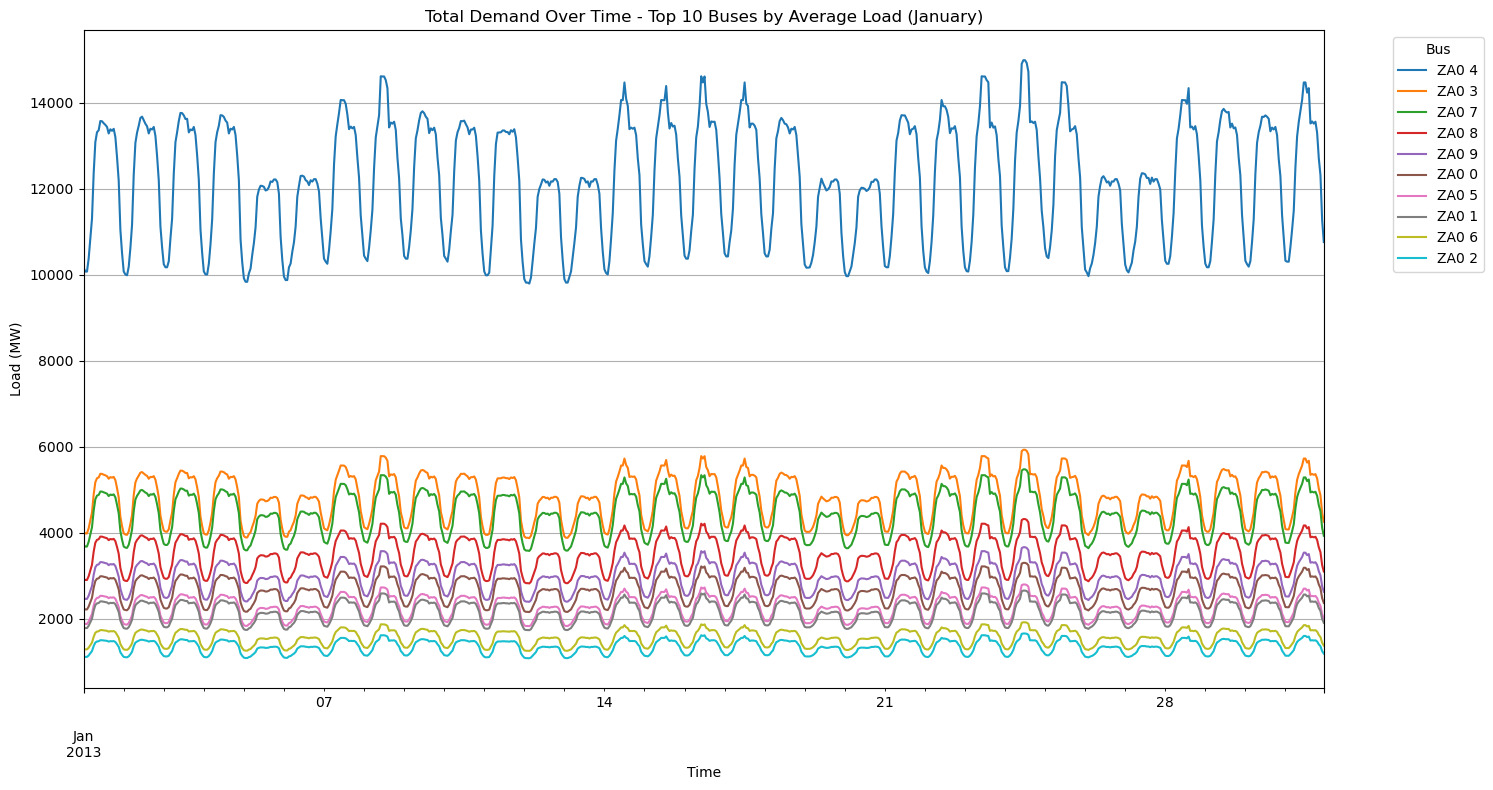

,ZA0 0,ZA0 1,ZA0 2,ZA0 3,ZA0 4,ZA0 5,ZA0 6,ZA0 7,ZA0 8,ZA0 9,ZA1 0,ZA2 0,ZA3 0
snapshot,,,,,,,,,,,,,
2013-01-01 00:00:00,2238.549587,1801.350559,1125.414339,4021.337885,10161.014524,1897.985290,1301.850661,3713.139762,2929.027863,2484.998582,883.738261,288.412937,459.504673
2013-01-01 01:00:00,2219.249560,1785.819916,1115.711392,3986.667252,10073.409649,1881.621494,1290.626539,3681.126310,2903.774763,2463.573754,876.118964,285.926337,455.542977
2013-01-01 02:00:00,2219.249560,1785.819916,1115.711392,3986.667252,10073.409649,1881.621494,1290.626539,3681.126310,2903.774763,2463.573754,876.118964,285.926337,455.542977
2013-01-01 03:00:00,2285.746017,1839.329309,1149.141997,4106.121708,10375.244137,1938.001437,1329.298211,3791.425694,2990.781983,2537.391016,902.370544,294.493687,469.192633
2013-01-01 04:00:00,2385.624702,1919.701228,1199.355271,4285.544108,10828.604104,2022.684964,1387.383649,3957.097037,3121.468143,2648.265661,941.800814,307.361977,489.694624
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-31 19:00:00,2929.998001,2357.755919,1473.034944,5263.458105,13299.572376,2484.239410,1703.969327,4860.063027,3833.752817,3252.570736,1156.709394,377.498597,601.437547
2013-01-31 20:00:00,2799.124431,2252.442558,1407.239219,5028.356390,12705.523329,2373.276440,1627.858508,4642.979670,3662.511431,3107.288881,1105.042913,360.636951,574.573270
2013-01-31 21:00:00,2712.617476,2182.830809,1363.748483,4872.955010,12312.859064,2299.930319,1577.549532,4499.488359,3549.321496,3011.258102,1070.891556,349.491464,556.816080


In [17]:
plot_bus_demand_over_time_with_months(network=n, months=[1])